In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/ann_svm_pca/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi
##!watch -n 1 nvidia-smi

Fri May 14 09:19:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

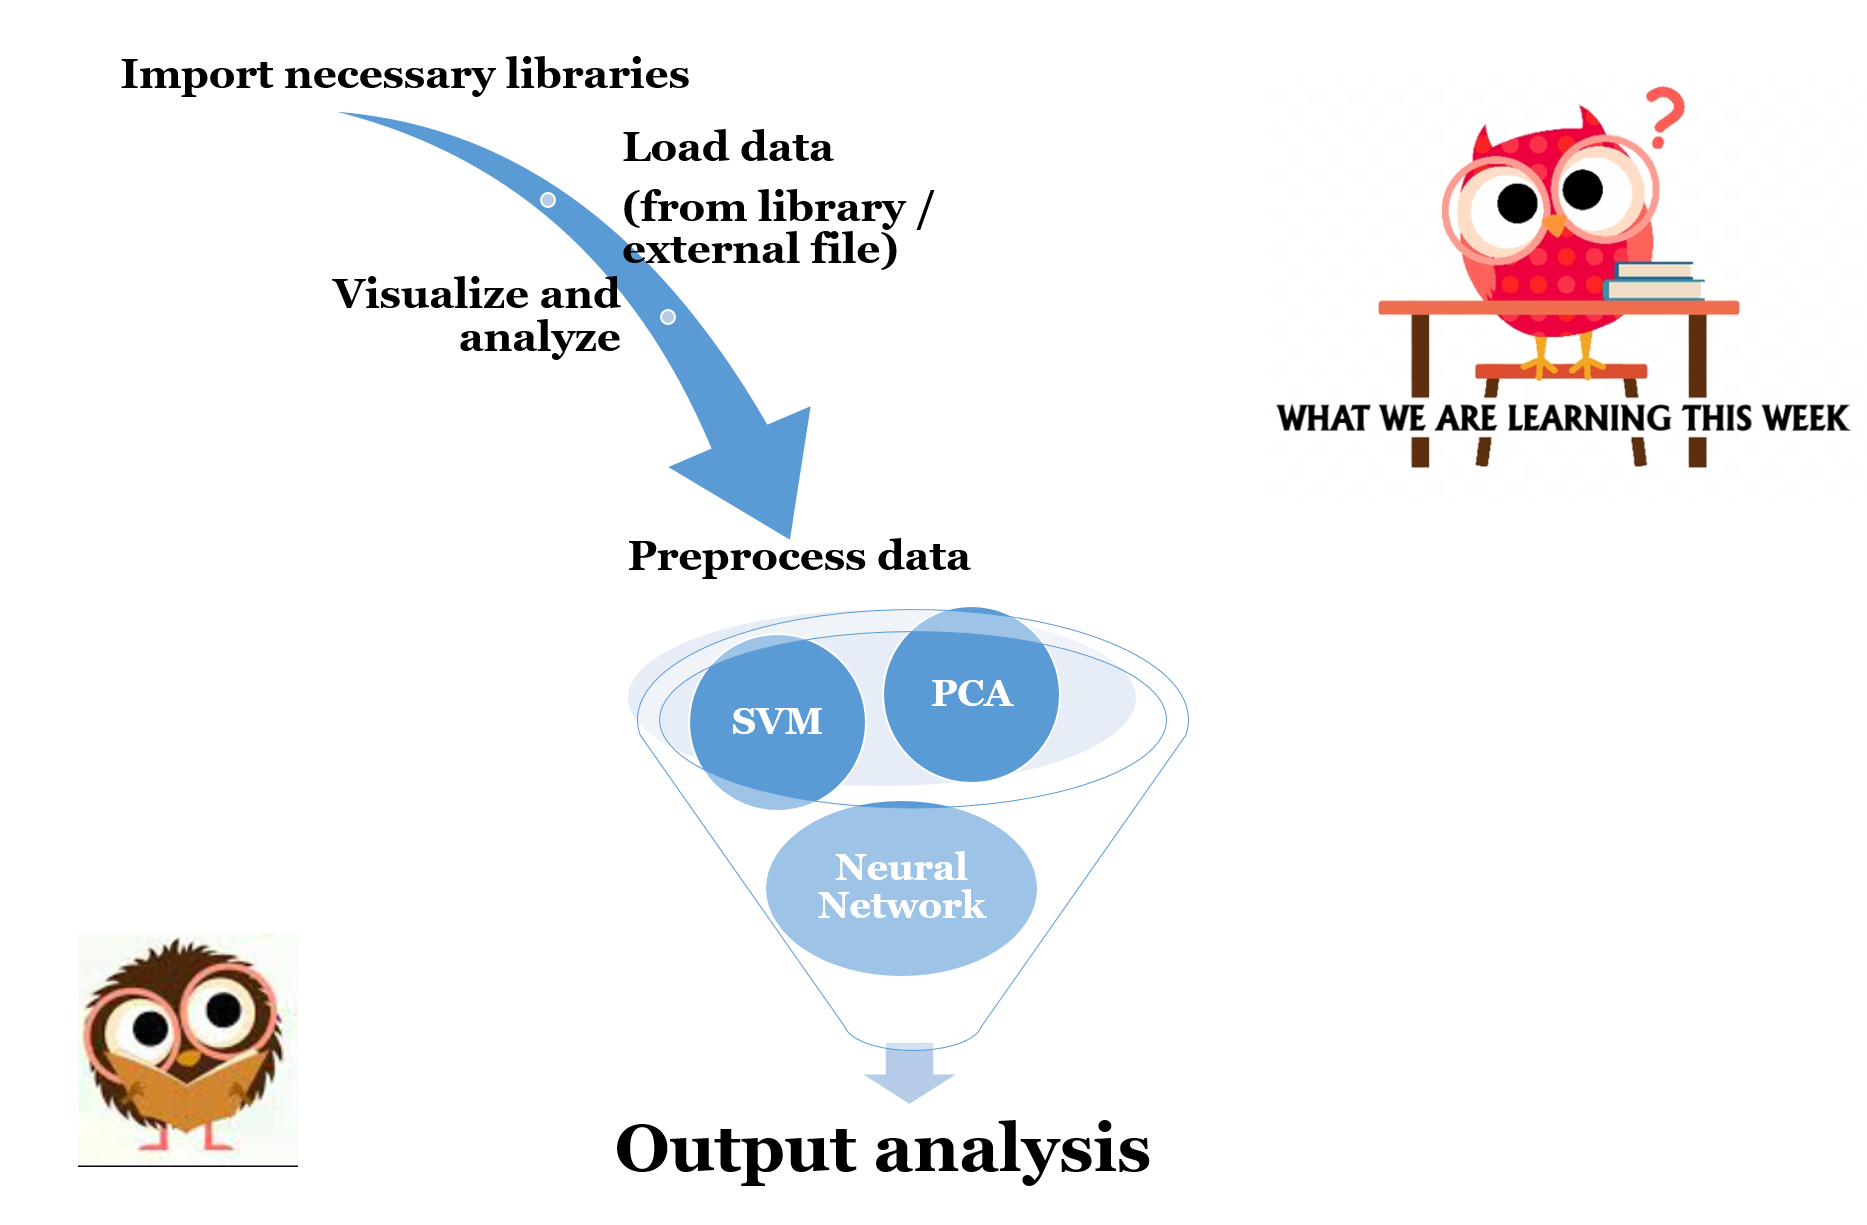

In [3]:
from IPython.display import Image, display
display(Image(filename='objectives.png', embed=True,  width = 600, height = 400))

# **Step1:**

---

Let us import all libraries here

In [4]:
!pip install mlxtend --upgrade --no-deps
!pip install livelossplot

     |████████████████████████████████| 1.4MB 28.0MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [5]:
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier 
from keras.models import Sequential
from keras.layers import Dense
from mlxtend.plotting import plot_confusion_matrix
from livelossplot import PlotLossesKeras

#from keras.layers import *

# **Step 2:**


---
Different ways to import data: 
(A) Read file using pandas library

In [6]:
data = pd.read_csv('diabetes.csv',header=None)
nrow,ncol = data.shape
print(data.head(10), "\n \n Number of rows and cols = ",nrow,ncol,"\n")
#pd.plotting.scatter_matrix(data);
#data.info()

    0    1   2   3    4     5      6   7  8
0   6  148  72  35    0  33.6  0.627  50  1
1   1   85  66  29    0  26.6  0.351  31  0
2   8  183  64   0    0  23.3  0.672  32  1
3   1   89  66  23   94  28.1  0.167  21  0
4   0  137  40  35  168  43.1  2.288  33  1
5   5  116  74   0    0  25.6  0.201  30  0
6   3   78  50  32   88  31.0  0.248  26  1
7  10  115   0   0    0  35.3  0.134  29  0
8   2  197  70  45  543  30.5  0.158  53  1
9   8  125  96   0    0   0.0  0.232  54  1 
 
 Number of rows and cols =  768 9 



(B) Import built-in datasets 

Scikit has toy datasets - Iris, diabetes , digits, cancer - for classification 

In [7]:
diabetes = datasets.load_diabetes()
x = diabetes.data
y = diabetes.target
print(x.shape, y.shape, diabetes.feature_names)


iris = datasets.load_iris()
x = iris.data
y = iris.target

print(x.shape, y.shape, iris.feature_names)

(442, 10) (442,) ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
(150, 4) (150,) ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


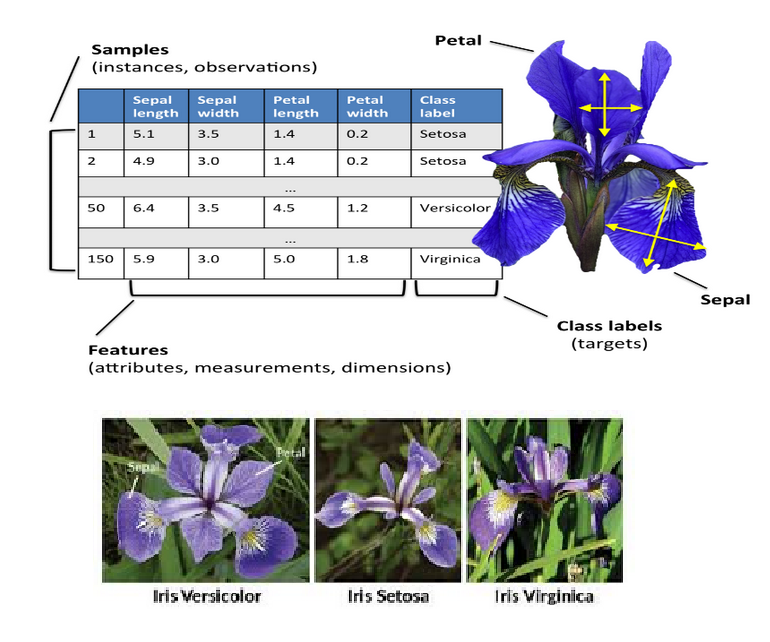

# **Step 3:**


---

Visualize data distribution


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


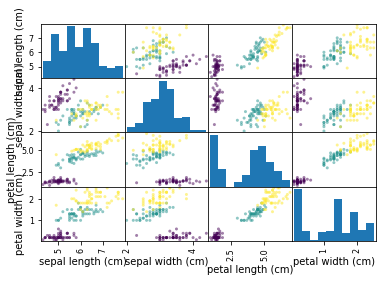

In [8]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
print(df.head())
pd.plotting.scatter_matrix(df, c = iris.target);

In [9]:
print("Variance of each feature\n",df.var(),"\n\nMean of each feature\n",df.mean())

Variance of each feature
 sepal length (cm)    0.685694
sepal width (cm)     0.189979
petal length (cm)    3.116278
petal width (cm)     0.581006
dtype: float64 

Mean of each feature
 sepal length (cm)    5.843333
sepal width (cm)     3.057333
petal length (cm)    3.758000
petal width (cm)     1.199333
dtype: float64


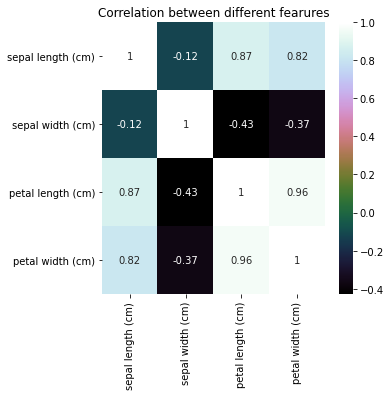

In [10]:
correlation = df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(correlation,annot=True,cmap='cubehelix')
plt.title('Correlation between different fearures');

# **Step 4:**


---

Preprocess data

1)   Split data for training and testing

In [11]:
### stratify ensures the ratio of target samples of each catergory is maintained in training and testing set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=12, stratify=y) 

*Let's just see the values of each of these*

In [12]:
print(x[0:5], "\n\n", x_train[0:5], "\n\n",x_test[0:5],"\n")
print(x.shape, x_train.shape, x_test.shape)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]] 

 [[6.7 2.5 5.8 1.8]
 [5.9 3.  5.1 1.8]
 [6.8 3.  5.5 2.1]
 [4.5 2.3 1.3 0.3]
 [5.1 3.4 1.5 0.2]] 

 [[5.8 2.7 5.1 1.9]
 [4.6 3.1 1.5 0.2]
 [4.3 3.  1.1 0.1]
 [6.2 2.9 4.3 1.3]
 [7.1 3.  5.9 2.1]] 

(150, 4) (120, 4) (30, 4)


2) Normalize data

In [13]:
scaler = StandardScaler()  
#scaler.fit(x_train)
x_train = scaler.fit_transform(x_train)  
x_test = scaler.fit_transform(x_test)  
x = scaler.fit_transform(x)

In [14]:
print(x[0:5], "\n\n", x_train[0:5], "\n\n",x_test[0:5],"\n")
print(x.shape, x_train.shape, x_test.shape)

[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]] 

 [[ 1.10096982 -1.25445029  1.18697941  0.80383146]
 [ 0.07879281 -0.14758239  0.78232734  0.80383146]
 [ 1.22874194 -0.14758239  1.01355709  1.20242558]
 [-1.71001695 -1.69719745 -1.41435533 -1.18913911]
 [-0.9433842   0.73791193 -1.29874045 -1.32200381]] 

 [[-0.06480868 -0.90293224  0.69260405  0.86826221]
 [-1.29276265  0.22573306 -1.23030693 -1.29180476]
 [-1.59975114 -0.05643326 -1.4439637  -1.41886752]
 [ 0.34450931 -0.33859959  0.2652905   0.10588564]
 [ 1.26547478 -0.05643326  1.1199176   1.12238774]] 

(150, 4) (120, 4) (30, 4)


# **Step 5 A: PCA**

---
PCA is used for dimensionality reduction.

In this example, we obtain the new transformed components and reconstruct the original data


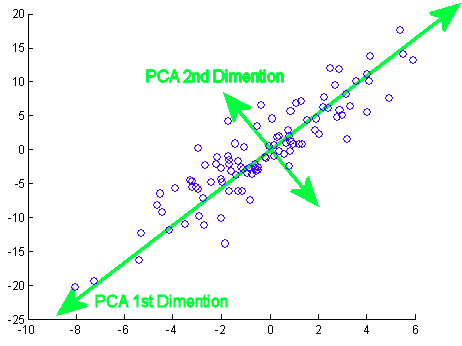


 The explained variance ratio  [0.72962445] 




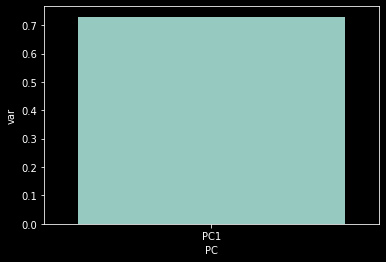

In [28]:
pca = PCA(n_components=1)  ## must be <= number of features in the data.
X_r = pca.fit(x).transform(x) ## fit command automatically obtains the eigen values of cov matrix of data. 
## transform is to obtain the transformed values of original features , we can use only fit, to obtain the principal components.

with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))
    df_new = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':['PC1']})
    sns.barplot(x='PC',y='var', data=df_new);

print("\n The explained variance ratio ", pca.explained_variance_ratio_, "\n\n")

In [29]:
  X_hat = pca.inverse_transform(X_r)
  print(X_hat[0:2],"\n\n", x[0:2])

[[-1.18005944  0.60999191 -1.31446317 -1.27923218]
 [-1.08431793  0.56050156 -1.2078171  -1.17544451]] 

 [[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]]


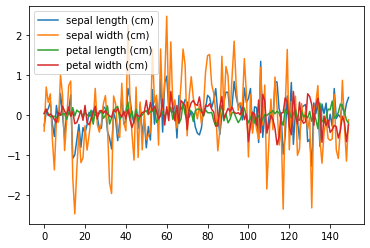

In [30]:
plt.plot(X_hat-x)
plt.legend(iris.feature_names)
plt.show()

## Things to try:


---


1.   Change the number of components in PCA to see the reconstruction error.
2.   Plot (scatter) the original values and the transformed features.
3.   Check whether the reconstruction error differs if the data is not normalized

# **Step 5 B** : SVM


---




Support vector machines are used for classifying non-linear separable data 

obtain the target values for test data

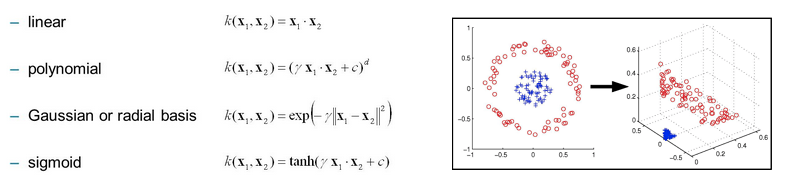

In [18]:
svc=SVC(kernel='poly')  ### kernel = 'rbf' 'linear' 'poly'
svc.fit(x_train,y_train)
y_pred=svc.predict(x_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
0.9666666666666667


Cross Validation

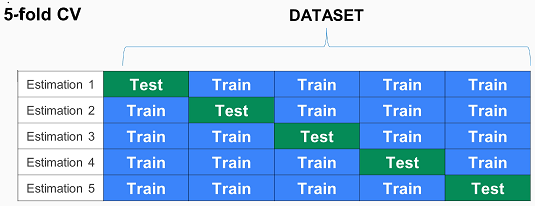

In [31]:
svc=SVC(kernel='rbf')
scores = cross_val_score(svc, x_train, y_train, cv=5, scoring='accuracy') #cv is cross validation
print(scores)
#print(scores.mean())

[0.875      0.95833333 0.95833333 0.91666667 1.        ]


Grid Search for hyperparameter tuning


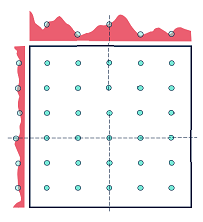

In [20]:
tuned_parameters = {
 'degree': [2,3,4,5] ,'gamma':[0.01,0.02,0.2,0.4,0.5, 0.8], 'C':(np.arange(0.1,1,0.1)) , 'kernel':['poly', 'rbf']
                   }

In [32]:
model_svm = GridSearchCV(svc, tuned_parameters,cv=5,scoring='accuracy')
model_svm.fit(x_train, y_train)
print(model_svm.best_score_)

0.9583333333333334


In [22]:
#print(model_svm.cv_results_)

print(model_svm.best_params_)

y_pred= model_svm.predict(x_test)
print("accuracy score:")
print(metrics.accuracy_score(y_pred,y_test))

{'C': 0.2, 'degree': 3, 'gamma': 0.8, 'kernel': 'poly'}
accuracy score:
0.9666666666666667


Obtain the classification report 

[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



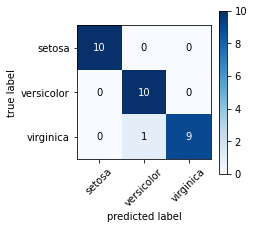

In [23]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, target_names=iris.target_names))
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, class_names = iris.target_names, figsize=(3,3))
plt.show()

## Things to Try:


1.   Perform Grid Search to obtain the accuracy above 98%
2.   Change the dataset and check the efficiency of SVM
3.   Obtain other classifier metrics such as specificity , sensitivity (suitable for diabetes dataset).
4.    Obtain the SVM for XOR data and visualize the output



# **Step 5 C:**  ANN - MLP

---
A simple multilayer perceptron is implemented on the same dataset


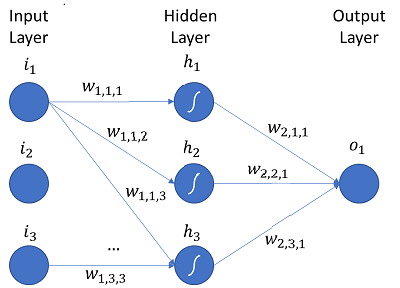

In [34]:
## ['identity', 'logistic', 'relu', 'softmax', 'tanh'].
mlps = MLPClassifier(hidden_layer_sizes=3, activation='relu', max_iter=500)   ## change hidden layer 
mlps.fit(x_train, y_train)
predictions = mlps.predict(x_test)  
print(" Score: ",mlps.score(x_test,y_test)); ###"with hidden Layer Size : ",mlps.hidden_layer_sizes," with standardization");

 Score:  0.9666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Using Keras

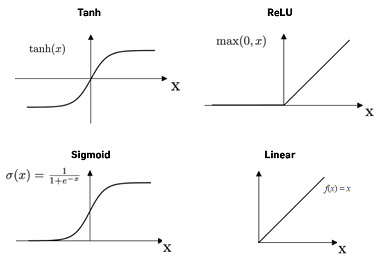

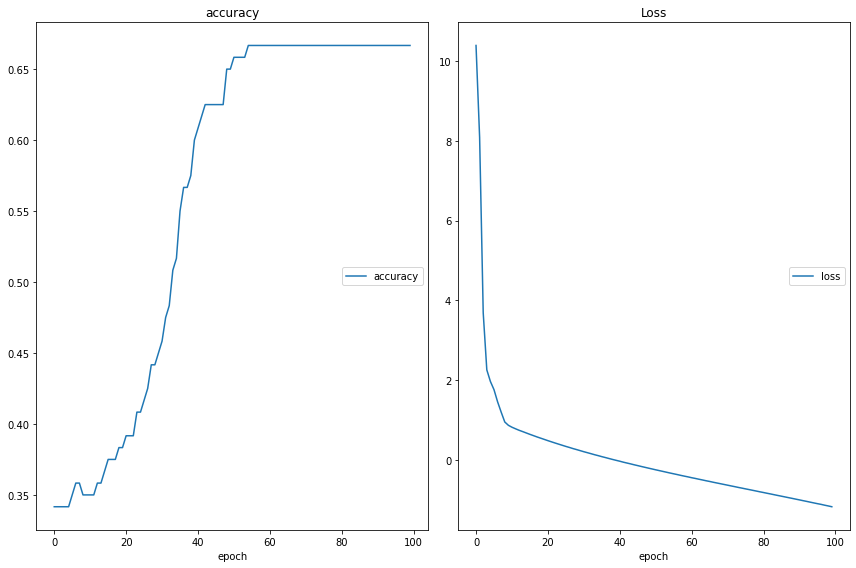

accuracy
	accuracy         	 (min:    0.342, max:    0.667, cur:    0.667)
Loss
	loss             	 (min:   -1.171, max:   10.388, cur:   -1.171)
1/1 [==============================] - 0s 129ms/step - loss: -1.1899 - accuracy: 0.6667

Loss: -1.19, Accuracy: 66.67%
Prediction Accuracy: 33.33%


In [25]:
model = Sequential()
model.add(Dense(12, input_dim=x_train.shape[1], activation='tanh'))
model.add(Dense(1, activation='tanh'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, batch_size=10, callbacks=[PlotLossesKeras()])

loss, accuracy = model.evaluate(x_test, y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
# 5. make predictions
probabilities = model.predict(x_test)
predictions = [float(np.round(x)) for x in probabilities]
accuracy = np.mean(predictions == y_test)
print("Prediction Accuracy: %.2f%%" % (accuracy*100))

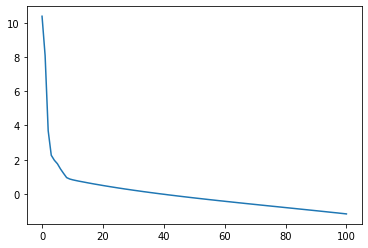

In [26]:
len_arr = len(history.history['loss'])

plt.plot(np.linspace(0,len_arr,len_arr),history.history['loss'])
plt.show()

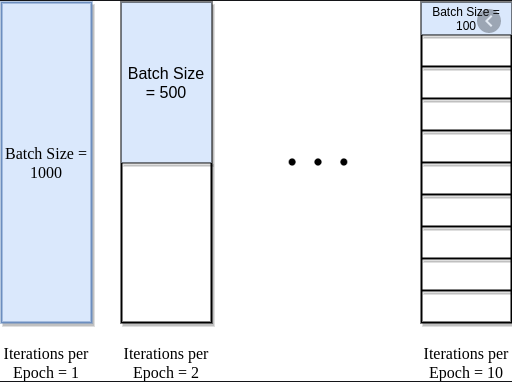

## Things to try:


---

1.   Hyperparameter tuning using Grid Search
2.   Change the model
3.   Change the dataset




APPLICATIONS OF PCA / SVM / ANN


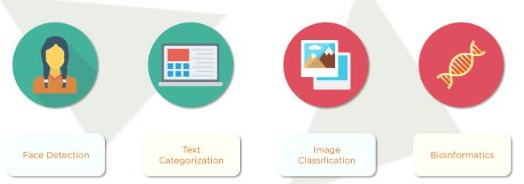